# Knapsack Problem with Genetic Algorithms

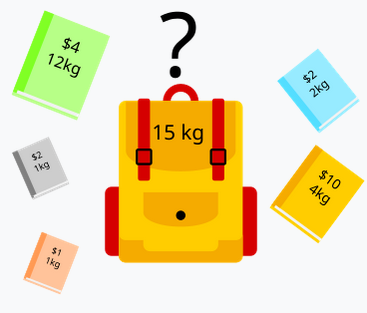         
Source: [Wikipedia](https://en.wikipedia.org/wiki/Knapsack_problem).

## Introduction

The [Knapsack Problem](https://en.wikipedia.org/wiki/Knapsack_problem) is a classical combinatorial optimization problem: given a set of items, each with a weight and a value, determine which items to include in a collection so that the total weight is less than or equal to a given limit (the capacity of the knapsack) and the total value is as large as possible.

In this notebook we'll implement a genetic algorithm to solve the 0-1 Knapsack Problem (each item can either be taken or left). The genetic algorithm approach allows us to find good solutions to this NP-hard problem without exhaustively searching all possible combinations. By adjusting parameters and operators, we can balance exploration and exploitation to find high-quality solutions efficiently.

## 1. Problem Setup

First, let's define our problem with a set of items, each having a value and weight.

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set a random seed for reproducibility
random.seed(42)
np.random.seed(42)

In [ ]:
class KnapsackProblem:
    def __init__(self, num_items=20, max_weight=50):
        """Initialize the knapsack problem with random items"""
        self.num_items = num_items
        self.max_weight = max_weight
        
        # Generate random weights (between 1 and 10)
        self.weights = [random.randint(1, 10) for _ in range(num_items)]
        
        # Generate random values (between 1 and 20)
        self.values = [random.randint(1, 20) for _ in range(num_items)]
        
    def display_items(self):
        """Display the items in a table format"""
        items_df = pd.DataFrame({
            'Item': range(1, self.num_items + 1),
            'Weight': self.weights,
            'Value': self.values,
            'Value/Weight': [v/w for v, w in zip(self.values, self.weights)]
        })
        return items_df
    
    def evaluate_solution(self, solution):
        """
        Evaluate a solution (binary list where 1 means item is selected)
        Returns a tuple of (total_value, total_weight, is_valid)
        """
        if len(solution) != self.num_items:
            raise ValueError("Solution length must match number of items")
            
        total_value = sum(v * s for v, s in zip(self.values, solution))
        total_weight = sum(w * s for w, s in zip(self.weights, solution))
        is_valid = total_weight <= self.max_weight
        
        return total_value, total_weight, is_valid

Now, we can create an instance of our problem and test a random solution. 

In [ ]:
problem = KnapsackProblem()
display(problem.display_items())

In [ ]:
# Test with a random solution
random_solution = [random.randint(0, 1) for _ in range(problem.num_items)]
total_value, total_weight, is_valid = problem.evaluate_solution(random_solution)

print(f"Random solution: {random_solution}")
print(f"Total value: {total_value}")
print(f"Total weight: {total_weight}")
print(f"Is valid: {is_valid}")

## 2. Greedy Solution (for Comparison)

Before implementing the genetic algorithm, let's create a greedy solution as a baseline to compare against.

In [ ]:
def greedy_solution(problem):
    """
    Create a greedy solution by selecting items in descending order of value/weight ratio
    until the knapsack is full.
    """
    # Calculate value/weight ratio for each item
    ratios = [(i, v/w) for i, (v, w) in enumerate(zip(problem.values, problem.weights))]
    
    # Sort by ratio in descending order
    ratios.sort(key=lambda x: x[1], reverse=True)
    
    # Initialize solution
    solution = [0] * problem.num_items
    total_weight = 0
    
    # Fill the knapsack greedily
    for idx, _ in ratios:
        if total_weight + problem.weights[idx] <= problem.max_weight:
            solution[idx] = 1
            total_weight += problem.weights[idx]
    
    return solution

In [ ]:
greedy_sol = greedy_solution(problem)
greedy_value, greedy_weight, _ = problem.evaluate_solution(greedy_sol)

print(f"Greedy solution: {greedy_sol}")
print(f"Greedy value: {greedy_value}")
print(f"Greedy weight: {greedy_weight}")

## 3. Implementing the Genetic Algorithm

Now, let's implement the genetic algorithm to solve the Knapsack Problem. We already have a representation for our solution as a binary chromosome. Now, we'll need to define:
- Fitness function
- Selection mechanism
- Crossover operator
- Mutation operator
- Replacement strategy

### 3.1 Fitness Function

The fitness function needs to evaluate how good a solution is, considering both value and weight constraints.

In [ ]:
def fitness_function(solution, problem):
    """
    Calculate fitness of a solution. If the solution is invalid (exceeds weight limit),
    apply a penalty.
    """
    total_value, total_weight, is_valid = problem.evaluate_solution(solution)
    
    if is_valid:
        return total_value
    else:
        # Apply a penalty for exceeding the weight limit
        excess_weight = total_weight - problem.max_weight
        penalty = excess_weight * 2  # Penalty factor can be adjusted
        return max(0, total_value - penalty)  # Ensure non-negative fitness

In [ ]:
# Test the fitness function
random_fitness = fitness_function(random_solution, problem)
print(f"Random solution fitness: {random_fitness}")

### 3.2 Selection Operator

Let's implement [tournament selection](https://en.wikipedia.org/wiki/Tournament_selection) to choose parents for reproduction.

In [ ]:
def tournament_selection(population, fitnesses, tournament_size=3):
    """
    Select an individual from the population using tournament selection.
    """
    # Randomly select tournament_size individuals
    tournament_indices = random.sample(range(len(population)), tournament_size)
    
    # Find the best individual in the tournament
    best_idx = tournament_indices[0]
    for idx in tournament_indices[1:]:
        if fitnesses[idx] > fitnesses[best_idx]:
            best_idx = idx
    
    return population[best_idx].copy()

### 3.3 Crossover Operator

We'll implement a single-point crossover for our binary representation.

In [ ]:
def single_point_crossover(parent1, parent2):
    """
    Perform single-point crossover between two parents.
    """
    if len(parent1) != len(parent2):
        raise ValueError("Parents must have the same length")
    
    # If parents are too short, return copies of them
    if len(parent1) < 2:
        return parent1.copy(), parent2.copy()
    
    # Select a random crossover point (not at the ends)
    crossover_point = random.randint(1, len(parent1) - 1)
    
    # Create children by crossing over parents
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    
    return child1, child2

In [ ]:
parent1 = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
parent2 = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]
child1, child2 = single_point_crossover(parent1, parent2)
print(f"Parent 1: {parent1}")
print(f"Parent 2: {parent2}")
print(f"Child 1: {child1}")
print(f"Child 2: {child2}")

### 3.4 Mutation Operator

For mutation, we'll flip bits with a small probability.

In [ ]:
def mutate(solution, mutation_rate=0.05):
    """
    Mutate a solution by flipping bits with probability mutation_rate.
    """
    mutated = solution.copy()
    for i in range(len(mutated)):
        if random.random() < mutation_rate:
            mutated[i] = 1 - mutated[i]  # Flip the bit
    
    return mutated

In [ ]:
# Test mutation
original = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
mutated = mutate(original, mutation_rate=0.2)  # Higher rate for demonstration
print(f"Original: {original}")
print(f"Mutated:  {mutated}")

### 3.5 Repair Operator (Optional but useful for Knapsack)

For the Knapsack Problem, it can be helpful to have a repair mechanism that makes invalid solutions valid.

In [ ]:
def repair_solution(solution, problem):
    """
    Repair an invalid solution by removing items until it's within weight limit.
    Start by removing items with lowest value/weight ratio.
    """
    # Calculate value/weight ratio for each selected item
    selected_items = [(i, problem.values[i]/problem.weights[i]) 
                      for i in range(len(solution)) if solution[i] == 1]
    
    # Sort by ratio in ascending order (remove lowest value/weight items first)
    selected_items.sort(key=lambda x: x[1])
    
    # Make a copy of the solution to repair
    repaired = solution.copy()
    total_weight = sum(w * s for w, s in zip(problem.weights, repaired))
    
    # Remove items until weight constraint is satisfied
    for idx, _ in selected_items:
        if total_weight <= problem.max_weight:
            break
        if repaired[idx] == 1:
            repaired[idx] = 0
            total_weight -= problem.weights[idx]
    
    return repaired

In [ ]:
# Test repair
# Create an intentionally overweight solution
overweight_solution = [1] * problem.num_items
_, overweight, is_valid = problem.evaluate_solution(overweight_solution)
print(f"Overweight solution weight: {overweight}, Is valid: {is_valid}")

# Repair it
repaired_solution = repair_solution(overweight_solution, problem)
_, repaired_weight, is_valid = problem.evaluate_solution(repaired_solution)
print(f"Repaired solution weight: {repaired_weight}, Is valid: {is_valid}")

### 3.6 Main Genetic Algorithm

Now let's put everything together in the main genetic algorithm function.

In [ ]:
def genetic_algorithm(problem, population_size=100, max_generations=200, 
                     crossover_rate=0.8, mutation_rate=0.05, tournament_size=10):
    """
    Solve the Knapsack Problem using a genetic algorithm.
    """
    # Initialize population with random solutions
    population = []
    for _ in range(population_size):
        # Generate a random solution (ensure length matches problem)
        solution = [random.randint(0, 1) for _ in range(problem.num_items)]
        population.append(solution)
    
    # Track the best solution found
    best_solution = None
    best_fitness = -1
    
    # Track fitness history for visualization
    avg_fitness_history = []
    best_fitness_history = []
    
    # Evolution loop
    for generation in range(max_generations):
        # Calculate fitness for each individual in the population
        fitnesses = [fitness_function(ind, problem) for ind in population]
        
        # Track statistics
        avg_fitness = sum(fitnesses) / len(fitnesses)
        current_best_idx = fitnesses.index(max(fitnesses))
        current_best_fitness = fitnesses[current_best_idx]
        current_best_solution = population[current_best_idx]
        
        avg_fitness_history.append(avg_fitness)
        best_fitness_history.append(current_best_fitness)
        
        # Update overall best if needed
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_solution = current_best_solution.copy()
        
        # Create the next generation
        new_population = []
        
        # Elitism: keep the best solution
        new_population.append(current_best_solution.copy())
        
        # Fill the rest of the population with offspring
        while len(new_population) < population_size:
            # Selection
            parent1 = tournament_selection(population, fitnesses, tournament_size)
            parent2 = tournament_selection(population, fitnesses, tournament_size)
            
            # Crossover
            if random.random() < crossover_rate:
                child1, child2 = single_point_crossover(parent1, parent2)
            else:
                child1, child2 = parent1.copy(), parent2.copy()
                
            # Mutation
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
                        
            # Add to new population
            new_population.append(child1)
            if len(new_population) < population_size:
                new_population.append(child2)
        
        # Replace old population
        population = new_population
        
    # Return the best solution found, its fitness, and history for plotting
    return best_solution, best_fitness, avg_fitness_history, best_fitness_history

In [ ]:
# Run the genetic algorithm
best_solution, best_fitness, avg_history, best_history = genetic_algorithm(problem)

In [ ]:
# Evaluate the best solution found
best_value, best_weight, is_valid = problem.evaluate_solution(best_solution)
print(f"\nBest solution found by GA:")
print(f"Selected items: {[i+1 for i in range(len(best_solution)) if best_solution[i] == 1]}")
print(f"Total value: {best_value}")
print(f"Total weight: {best_weight}/{problem.max_weight}")
print(f"Is valid: {is_valid}")

# Compare with greedy solution
print(f"\nGreedy solution:")
print(f"Selected items: {[i+1 for i in range(len(greedy_sol)) if greedy_sol[i] == 1]}")
print(f"Total value: {greedy_value}")
print(f"Total weight: {greedy_weight}/{problem.max_weight}")

# Plot the fitness history
plt.figure(figsize=(12, 6))
plt.plot(avg_history, label='Average Fitness')
plt.plot(best_history, label='Best Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness Evolution')
plt.legend()
plt.grid(True)
plt.show()

## 4. Analysis and Extensions

Now that we have implemented the genetic algorithm, let's analyze its performance and explore some extensions.

In [ ]:
def visualize_solution(solution, problem):
    """Visualize the selected items in the solution"""
    solution_df = pd.DataFrame({
        'Item': range(1, problem.num_items + 1),
        'Weight': problem.weights,
        'Value': problem.values,
        'Value/Weight': [v/w for v, w in zip(problem.values, problem.weights)],
        'Selected': ["Yes" if s == 1 else "No" for s in solution]
    })
    
    # Highlight selected items
    def highlight_selected(s):
        return ['background-color: darkgreen' if val == "Yes" else '' for val in s]
    
    return solution_df.style.apply(highlight_selected, subset=['Selected'])

In [ ]:
display(visualize_solution(best_solution, problem))

### 4.1 Different Parameter Settings

Let's explore how different parameter settings affect the algorithm's performance.

In [ ]:
def run_parameter_experiment(problem):
    # Define parameter combinations to test
    population_sizes = [50, 100, 200]
    mutation_rates = [0.01, 0.05, 0.1]
    
    results = []
    
    for pop_size in population_sizes:
        for mut_rate in mutation_rates:
            # Run GA with these parameters
            best_sol, best_fit, _, _ = genetic_algorithm(
                problem, 
                population_size=pop_size,
                mutation_rate=mut_rate,
                max_generations=100  # Reduced for faster experimentation
            )
            
            # Evaluate the solution
            best_value, best_weight, is_valid = problem.evaluate_solution(best_sol)
            
            # Record results
            results.append({
                'Population Size': pop_size,
                'Mutation Rate': mut_rate,
                'Best Value': best_value,
                'Weight': best_weight,
                'Valid': is_valid
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
parameter_results = run_parameter_experiment(problem)
display(parameter_results)

## 5. Exercises

### Exercise 1: Repair Mechanism 

Modify the main GA function to use the repair mechanism we implemented earlier. How does it affect the performance of the algorithm? 

### Exercise 2: Crossover Operators 

Implement other crossover operators: [uniform crossover](https://en.wikipedia.org/wiki/Crossover_(evolutionary_algorithm)#Uniform_crossover), [two-point crossover](https://en.wikipedia.org/wiki/Crossover_(evolutionary_algorithm)#Two-point_and_k-point_crossover), [order crossover](https://en.wikipedia.org/wiki/Crossover_(evolutionary_algorithm)#Order_crossover_(OX1)) and compare the performance with single-point crossover.

```python
def uniform_crossover(parent1, parent2, prob=0.5):
    """
    Perform uniform crossover between two parents.
    For each gene position, randomly select which parent contributes to each child.
    """
    # your code 
    return child1, child2
```
```python
def two_point_crossover(parent1, parent2):
    """
    Perform two-point crossover between two parents.
    """
    # you code 
    return child1, child2 
```
```python
def order_crossover(parent1, parent2):
    """
    Perform order crossover (OX) between two parents.
    This preserves relative ordering and is often used for permutation problems,
    but can also be used for binary representations.
    """
    # your code 
    return child1, child2 
```
Modify the main GA function to use different crossover methods and run experiments to compare them. 

### Exercise 3: Fitness Functions

Modify the fitness function to use a different penalty strategy for invalid solutions. How does this affect the algorithm's ability to find valid solutions? Consider the following options:    

-  Calculate fitness with a logarithmic penalty for weight violations. This provides a more gradual penalty as the weight excess increases.
-  Calculate fitness with a quadratic penalty for weight violations. This penalizes larger violations more harshly.
-  Calculate fitness by considering value per unit of excess weight. This encourages solutions that give high value even if they're invalid.